# Algorithms (movement detection)
This notebook is meant for extracting and analysising different implemented methods for movement detection on the corresponding satellite imagery.

! Important: This notebook was tested only in Colab enviroment. In order to execute certain cell other task have to be completed before hand including mounting the google drive.

In [1]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 32.5 MB/s eta 0:00:00


In [38]:
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import cv2
from PIL import Image as im
from datetime import date
from skimage.exposure import match_histograms
from skimage.metrics import structural_similarity

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

import matplotlib.image as mpimg

In [3]:
img_path = "/content/drive/MyDrive/FINAL_project/masked_norm_hm_coreg_L1C_png"

image_lst = []

for img_file in os.listdir(img_path):
    full_path = os.path.join(img_path, img_file)
    date_id = img_file.rsplit("_", 1)[1].rsplit(".", 1)[0].rsplit("T", 1)[0]
    im_data = cv2.imread(full_path)
    im_data = cv2.cvtColor(im_data, cv2.COLOR_BGR2RGB)

    image_lst.append((date(int(date_id[:4]), int(date_id[4:6]), int(date_id[6:])), im_data/255))

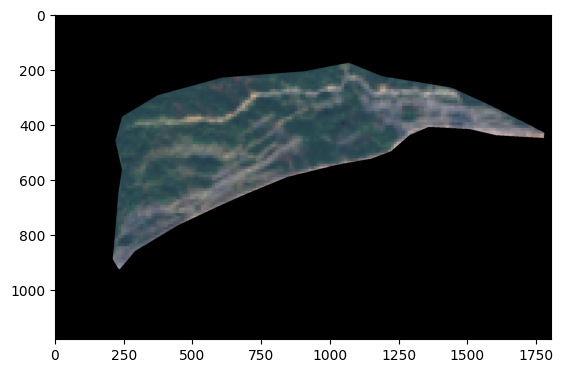

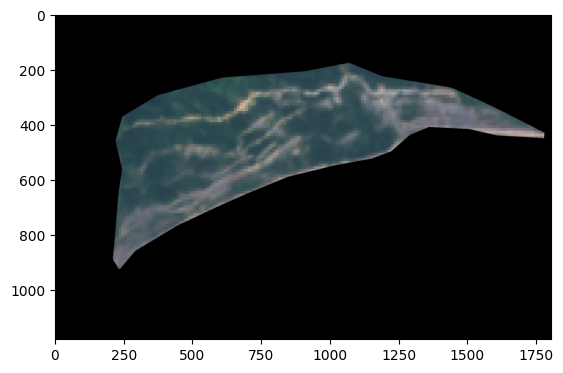

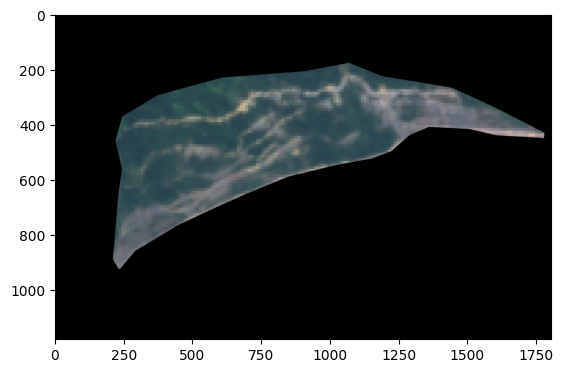

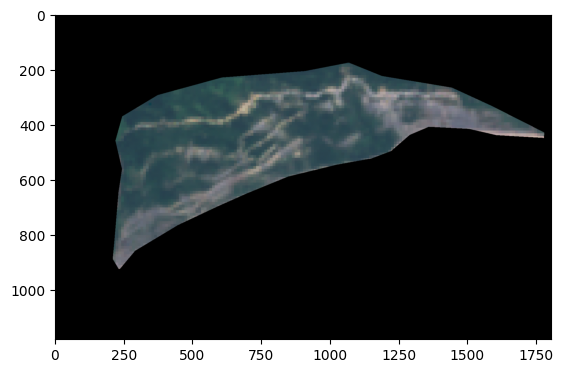

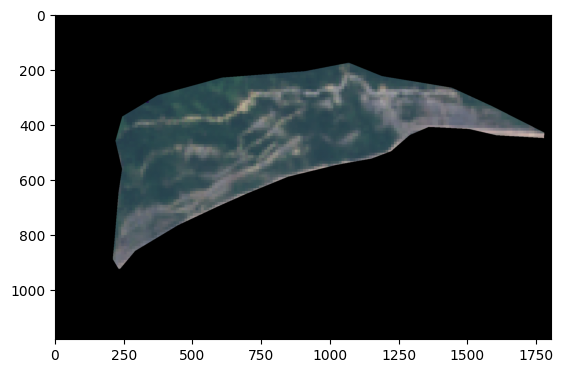

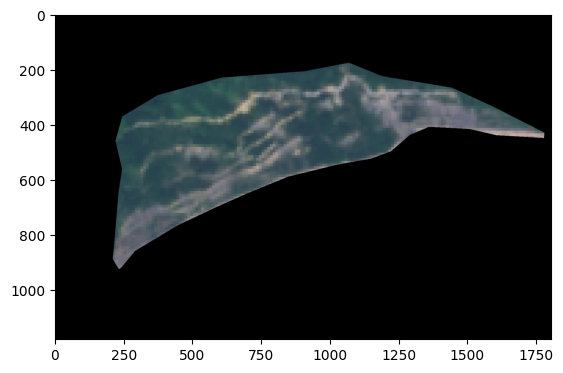

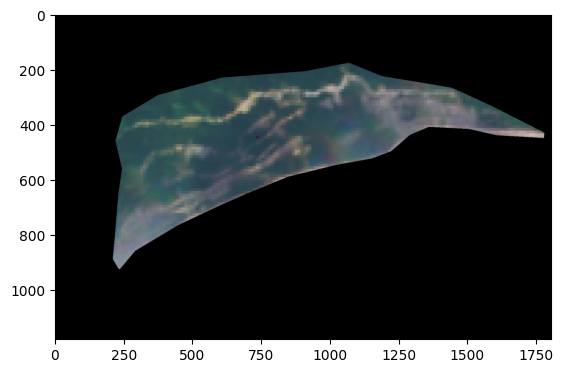

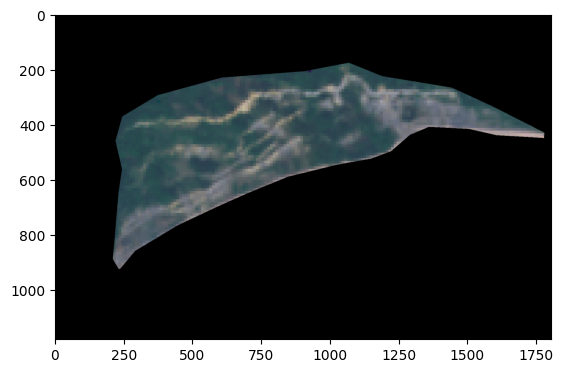

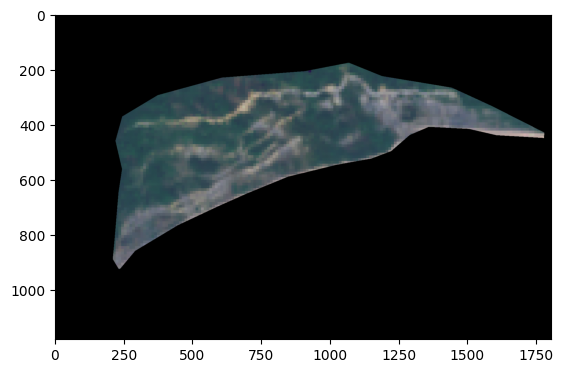

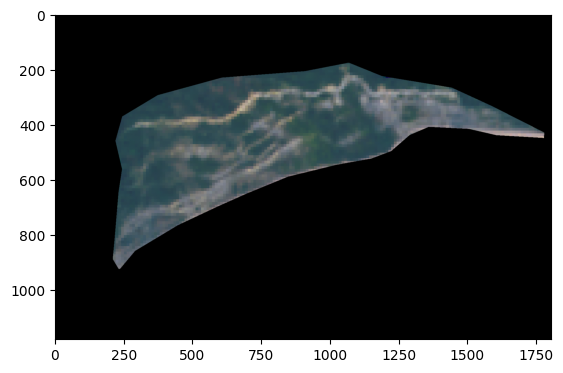

In [4]:
for i in range(10):
    plt.figure()
    plt.imshow(image_lst[i][1])

In [5]:
# Sort the list by date
sorted_files = sorted(image_lst, key=lambda x: x[0], reverse=False)
print(sorted_files[0][0])

2015-09-10


In [6]:
# Create pairs of images
img_pairs = []
for i in range(len(sorted_files)-1):

    # First frame
    first_f = sorted_files[i]
    next_f = sorted_files[i+1]
    img_pairs.append([first_f, next_f])


## 1. Dense optical flow

In [7]:
# Read first image
first_frame = np.uint8(sorted_files[0][1]*255)
# Convert to gray scale
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Create mask
mask = np.zeros_like(first_frame)
# Set image saturation to maximum value as we do not need it
mask[:, :, 1] = 255

results_output = "/content/drive/MyDrive/FINAL_project/optical_flow_hm_coreg_L1C"
###
###### Dense optical flow
###

out_collection = []

for i in range(1, len(sorted_files)):

    # Read the next image
    frame =  np.uint8(sorted_files[i][1]*255)
    if i == 1:
      matched = match_histograms(frame, first_frame, channel_axis=-1)
    else:
      matched = match_histograms(frame, prev_frame, channel_axis=-1)
    # Create mask
    mask = np.zeros_like(first_frame)
    # Set image saturation to maximum value as we do not need it
    mask[:, :, 1] = 255
    # Convert new frame format`s to gray scale and resize gray frame obtained
    gray = cv2.cvtColor(matched, cv2.COLOR_BGR2GRAY)

    # Calculate dense optical flow by Farneback method
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale = 0.5, levels = 5, winsize = 13, iterations = 10, poly_n = 5, poly_sigma = 1.1, flags = 0)

    # Compute the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[:, :, 0], flow[:, :, 1])
    # Set image hue from OF detected direction
    mask[:, :, 0] = angle * 180 / np.pi / 2
    # Set image value from OF magnitude (normalized)
    mask[:, :, 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    cv2.imwrite(os.path.join(results_output, f"mask_{sorted_files[i-1][0]}_{sorted_files[i][0]}.png"), rgb)

    # Add the mask to the first frame
    if i == 1:
      dense_flow = cv2.addWeighted(first_frame, 1, rgb, 1, 0)
      # Save the results
      out_collection.append([sorted_files[i][0], first_frame, frame, rgb, dense_flow])
    else:
      dense_flow = cv2.addWeighted(prev_frame, 1, rgb, 1, 0)
      # Save the results
      out_collection.append([sorted_files[i][0], prev_frame, frame, rgb, dense_flow])

    cv2.imwrite(os.path.join(results_output, f"combined_{sorted_files[i-1][0]}_{sorted_files[i][0]}.png"), dense_flow)

    # Update previous frame
    prev_gray = gray
    prev_frame = frame

In [9]:
for i in range(0,90,5):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 8))
    for aa in (ax1, ax2):
        aa.set_axis_off()

    ax1.imshow(out_collection[i][1])
    ax1.set_title(f'First frame: {sorted_files[i][0]}')

    ax2.imshow(out_collection[i][2])
    ax2.set_title(f'Second frame: {sorted_files[i+1][0]}')

    ax3.imshow(out_collection[i][3])
    ax3.set_title(f'Optical flow (mask)')

    ax4.imshow(out_collection[i][4])
    ax4.set_title('Optical flow (combined)')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 2. Feature tracking

In [27]:
def implement_FAST_matching(image_pair_lst):
    """
    Feature matching with FAST and BRIEF algorithm and FLANN matching
    """
    computed_features = []
    for image in image_pair_lst:
        img1 = np.uint8(image[0][1]*255)
        img2 = np.uint8(image[1][1]*255)

        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        # Initialize the FAST detector and BRIEF descriptor
        fast = cv2.xfeatures2d.StarDetector_create()
        brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

        # Detector
        kp = fast.detect(img1,None)
        kp = fast.detect(img2,None)

        # Descriptor for both images
        kp1, des1 = brief.compute(img1, kp)
        kp2, des2 = brief.compute(img2, kp)

        # Draw the keypoints on the image
        img1_kp = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
        # plt.figure()
        # plt.imshow(img1_kp)
        # plt.show()

        # Draw the keypoints on the image
        img2_kp = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)
        # plt.figure()
        # plt.imshow(img2_kp)
        # plt.show()

        # FLANN matching
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)

        matches = flann.knnMatch(np.float32(des1),np.float32(des2),k=2) # Use NP.FLOAT32 for ORB, BRIEF, etc

        # store all the good matches as per Lowe's ratio test.
        good_matches = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good_matches.append(m)

        if len(good_matches)>10:
            p1 = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
            p2 = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                            singlePointColor = None,
                            flags = 2)

        print(f"Number of good matches ({image[0][0]} to {image[1][0]})", len(good_matches))

        img_briefmatch = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)
        # Displaying the image
        output_path = os.path.join("/content/drive/MyDrive/FINAL_project/feature_matching_FAST_L1C",f"comp_{image[0][0]}_{image[1][0]}.png")
        cv2.imwrite(output_path, img_briefmatch)

In [37]:
def implement_SIFT_matching(images_list):
    """Feature matching with SIFT and KNN.
      Input data: List of paired images (first and next images)
    """
    computed_features = []
    for image in images_list:
        img1 = np.uint8(image[0][1]*255)
        img2 = np.uint8(image[1][1]*255)
        # Convert to gray scale images
        gray1 = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)

        # Initiate SIFT detector
        sift = cv2.SIFT_create()
        # extract features from the images
        keypoint1, descriptors1 = sift.detectAndCompute(gray1, None)
        keypoint2, descriptors2 = sift.detectAndCompute(gray2, None)

        # finding nearest match with KNN algorithm in Flann method
        index_params = dict(algorithm=0, trees=20)
        search_params = dict(checks=50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)

        matches = flann.knnMatch(descriptors1, descriptors2, k=2)

        # Create a mask
        good_matches = [[0, 0] for i in range(len(matches))]

        # Good matches
        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                good_matches[i] = [1, 0]

        kps1 = np.float32([kp.pt for kp in keypoint1])
        kps2 = np.float32([kp.pt for kp in keypoint2])
        # Compute SSIM between the two images
        (score, diff) = structural_similarity(gray1, gray2, full=True)

        # Draw the matches
        matched_img = cv2.drawMatchesKnn(gray1,
                                    keypoint1,
                                    gray2,
                                    keypoint2,
                                    matches,
                                    outImg=None,
                                    matchColor=(0, 155, 0),
                                    singlePointColor=(0, 255, 255),
                                    matchesMask=good_matches,
                                    flags=0
                                    )

        # Displaying the image
        output_path = os.path.join("/content/drive/MyDrive/FINAL_project/feature_matching_SIFT_L1C",f"comp_{image[0][0]}_{image[1][0]}.png")
        cv2.imwrite(output_path, matched_img)

        computed_features.append([image[0][0], image[1][0], len(matches), len(good_matches), score * 100])

    return computed_features

In [40]:
# Run the feature matching - SIFT
extracted_p = implement_SIFT_matching(img_pairs)
extracted_df = pd.DataFrame(extracted_p, columns=["first_date", "next_date", "matches", "n_good_pts", "sim_score"])

In [43]:
extracted_df

,first_date,next_date,matches,n_good_pts,sim_score
0,2015-09-10,2015-09-30,244,244,99.544747
1,2015-09-30,2015-10-20,324,324,99.595258
2,2015-10-20,2016-07-19,381,381,97.263880
3,2016-07-19,2016-08-15,650,650,99.452975
4,2016-08-15,2016-11-06,455,455,97.601268
...,...,...,...,...,...
100,2022-06-20,2022-08-07,427,427,98.953783
101,2022-08-07,2022-08-09,390,390,96.292326
102,2022-08-09,2022-08-12,612,612,96.651145
103,2022-08-12,2022-08-14,426,426,99.428420


In [44]:
# Run the feature matching - FAST
implement_FAST_matching(img_pairs)

Number of good matches (2015-09-10 to 2015-09-30) 11
Number of good matches (2015-09-30 to 2015-10-20) 11
Number of good matches (2015-10-20 to 2016-07-19) 4
Number of good matches (2016-07-19 to 2016-08-15) 10
Number of good matches (2016-08-15 to 2016-11-06) 7
Number of good matches (2016-11-06 to 2017-01-25) 6
Number of good matches (2017-01-25 to 2017-03-13) 7
Number of good matches (2017-03-13 to 2017-05-25) 12
Number of good matches (2017-05-25 to 2017-06-01) 6
Number of good matches (2017-06-01 to 2017-06-21) 10
Number of good matches (2017-06-21 to 2017-07-01) 10
Number of good matches (2017-07-01 to 2017-07-06) 11
Number of good matches (2017-07-06 to 2017-07-24) 13
Number of good matches (2017-07-24 to 2017-10-27) 4
Number of good matches (2017-10-27 to 2017-11-08) 16
Number of good matches (2017-11-08 to 2018-02-24) 8
Number of good matches (2018-02-24 to 2018-04-20) 11
Number of good matches (2018-04-20 to 2018-05-05) 8
Number of good matches (2018-05-05 to 2018-05-07) 7
Nu

## 3. PCA and Kmeans algorithm

In [8]:
def find_vector_set(diff_image, new_size):
    """Function create non-overlapping
    blocks of size 5 x 5 from the
    difference image and flatten them into row vectors"""

    i = 0
    j = 0
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 25), 25))
    #Iterates through the vector set
    while i < vector_set.shape[0]:
        while j < new_size[0]:
            k = 0
            while k < new_size[1]:
                # Extracts the 5 x 5 window
                block = diff_image[j:j+5, k:k+5]
                # Flattens it
                feature = block.ravel()
                # Adds it to the vectore set
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1
    # Calculates the mean
    mean_vec = np.mean(vector_set, axis = 0)
    vector_set = vector_set - mean_vec

    return vector_set, mean_vec

In [9]:
def find_FVS(EVS, diff_image, mean_vec, new):
    """Function determines the feature vector space"""

    i = 2
    feature_vector_set = []
    # Iterates through the difference imagery and extracts the vectors
    while i < new[0] - 2:
        j = 2
        while j < new[1] - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1
    # Creates the feature space
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec

    return FVS

In [45]:
def clustering(FVS, components, new):
    """Function uses the K-means algorithm to
    cluster it so that the pixels can be grouped into two disjoint classes
    """
    # Initialises the Kmeans algorithm
    kmeans = KMeans(components, verbose = 0)
    # Fits it to the data
    kmeans.fit(FVS)
    #Predicts
    output = kmeans.predict(FVS)
    count  = Counter(output)

    least_index = min(count, key = count.get)
    print(new[0],new[1])
    change_map  = np.reshape(output,(new[0] - 4, new[1] - 4))

    return least_index, change_map

In [39]:
def find_PCAKmeans(image1, image2):
    """Function that implements both Feature vector space, PCA and KMeans cluster
    to"""
    image1 = cv2.cvtColor(np.uint8(image1*255), cv2.COLOR_BGR2GRAY)
    image2 = cv2.cvtColor(np.uint8(image2*255), cv2.COLOR_BGR2GRAY)

    new_size = np.asarray(image1.shape) / 5
    new_size = new_size.astype(int) * 5

    image1 = cv2.resize(image1, (new_size[1], new_size[0]))
    image1 = np.array(image1,dtype=np.uint16)
    image2 = cv2.resize(image2, (new_size[1], new_size[0]))
    image2 = np.array(image2,dtype=np.uint16)


    diff_image = abs(image1 - image2)
    #cv2.imwrite('diff.jpg', diff_image)


    vector_set, mean_vec = find_vector_set(diff_image, new_size)

    pca = PCA()
    pca.fit(vector_set)
    EVS = pca.components_

    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)

    components = 3
    least_index, change_map = clustering(FVS, components, new_size)

    change_map[change_map == least_index] = 255 ## change map formula
    change_map[change_map != 255] = 0

    change_map = change_map.astype(np.uint8)
    #cv2.imwrite('change_map.png', change_map)
    # Creating kernel
    kernel = np.asarray(((0,0,1,0,0),
                        (0,1,1,1,0),
                        (1,1,1,1,1),
                        (0,1,1,1,0),
                        (0,0,1,0,0)), dtype=np.uint8)
    clean_change_map = cv2.erode(change_map, kernel)

    #cleanChangeMap = cv2.medianBlur(change_map,5)
    # ret, mask = cv2.threshold(change_map, 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
    # difference = np.zeros_like(image1)
    # difference[mask != 255] = [0, 0, 255]
    #cv2.imwrite('clean_change_map.png', clean_change_map)
    return diff_image, change_map, clean_change_map

In [43]:
## Compare the  results
def plot_result_comparison(source, reference, result, save_flag=False, filename="", output_dir="./"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                        sharex=True, sharey=True)
    for aa in (ax1, ax2, ax3):
        aa.set_axis_off()

    ax1.imshow(source)
    ax1.set_title('Difference frame')
    ax2.imshow(reference)
    ax2.set_title('Change frame')
    ax3.imshow(result)
    ax3.set_title('Eroded Change')

    plt.tight_layout()
    if save_flag:
        plt.savefig(os.path.join(output_dir, f"pca_km_{filename}.png"))
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


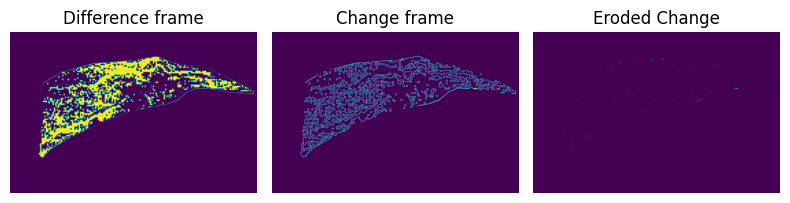

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


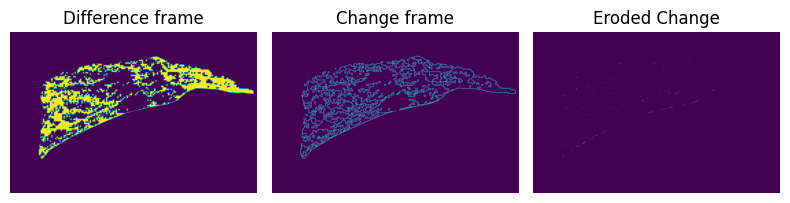

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


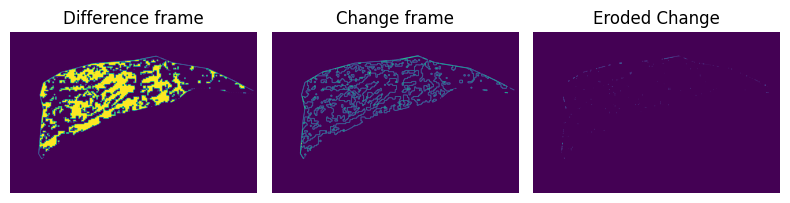

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


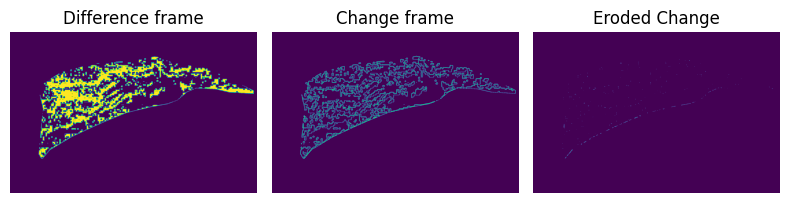

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


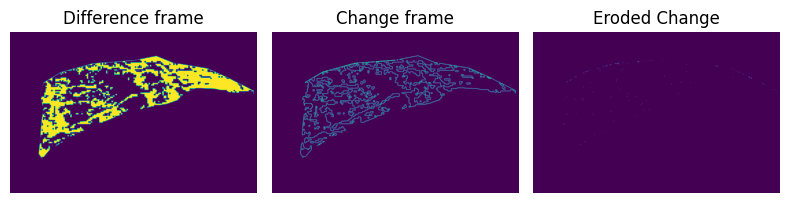

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


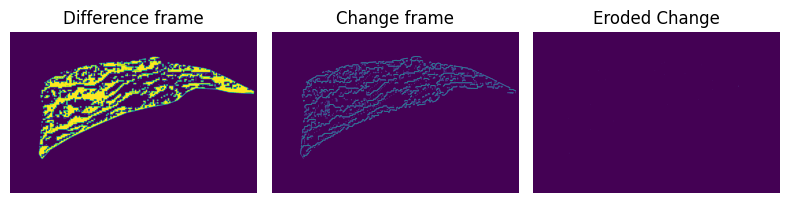

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


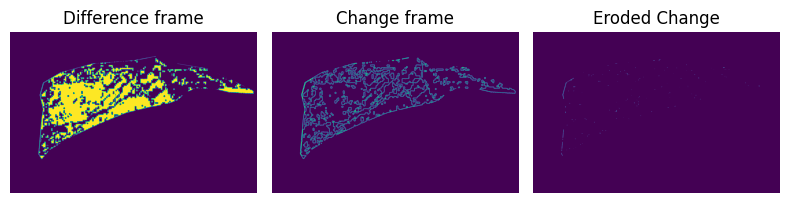

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


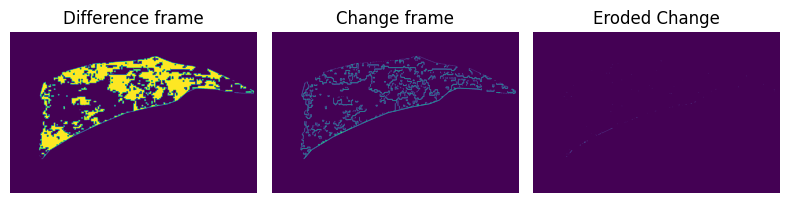

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


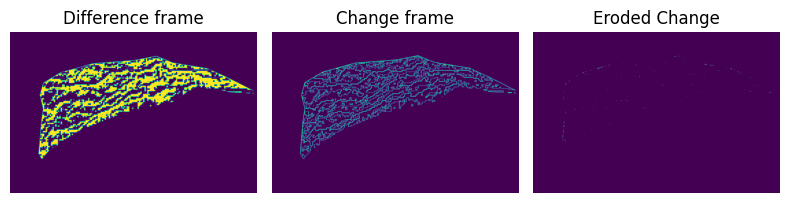

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1175 1800


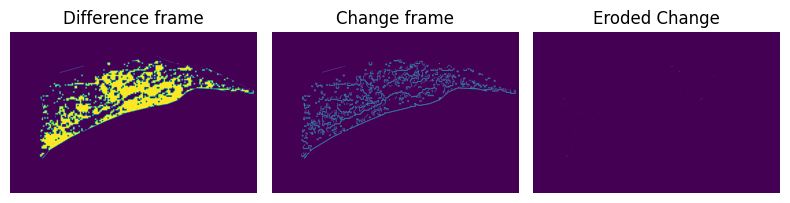

In [44]:
for i in range(10):
    diff_image, change_map, cleanChangeMap = find_PCAKmeans(img_pairs[i][0][1], img_pairs[i][1][1])

    plot_result_comparison(diff_image, change_map, cleanChangeMap)